###1. Overview of GRU
A Gated Recurrent Unit (GRU) is a type of recurrent neural network architecture designed to better capture long-term dependencies in sequence data. GRU cells use update and reset gates to solve the vanishing gradient problem that traditional RNNs face.
The key advantages of GRUs include:

Efficient handling of sequential data
Better memory of long-term dependencies
Faster training compared to LSTMs while maintaining similar performance

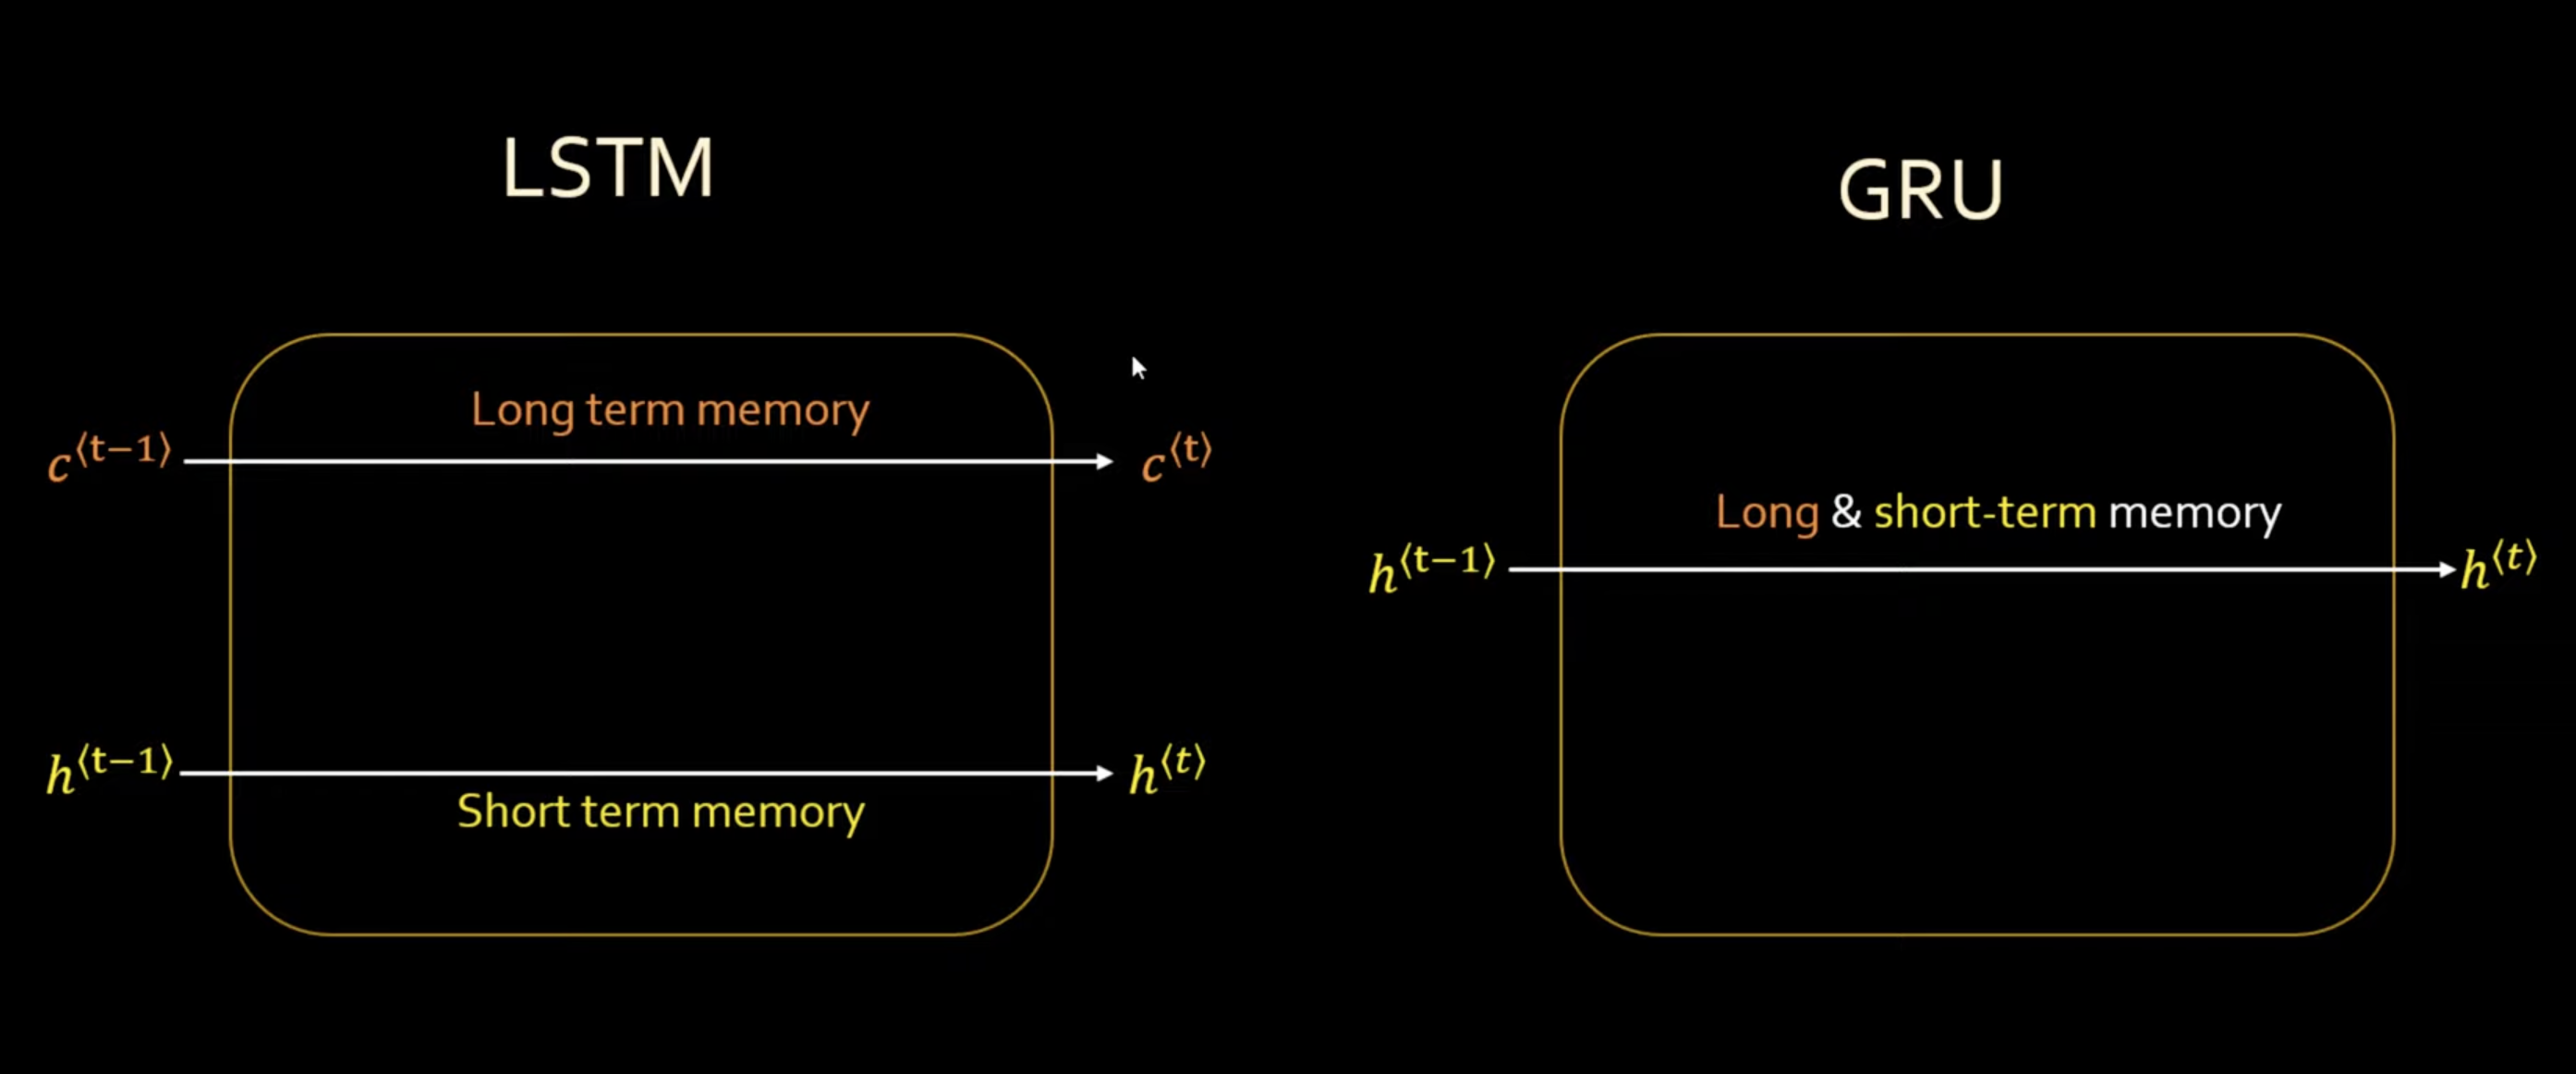

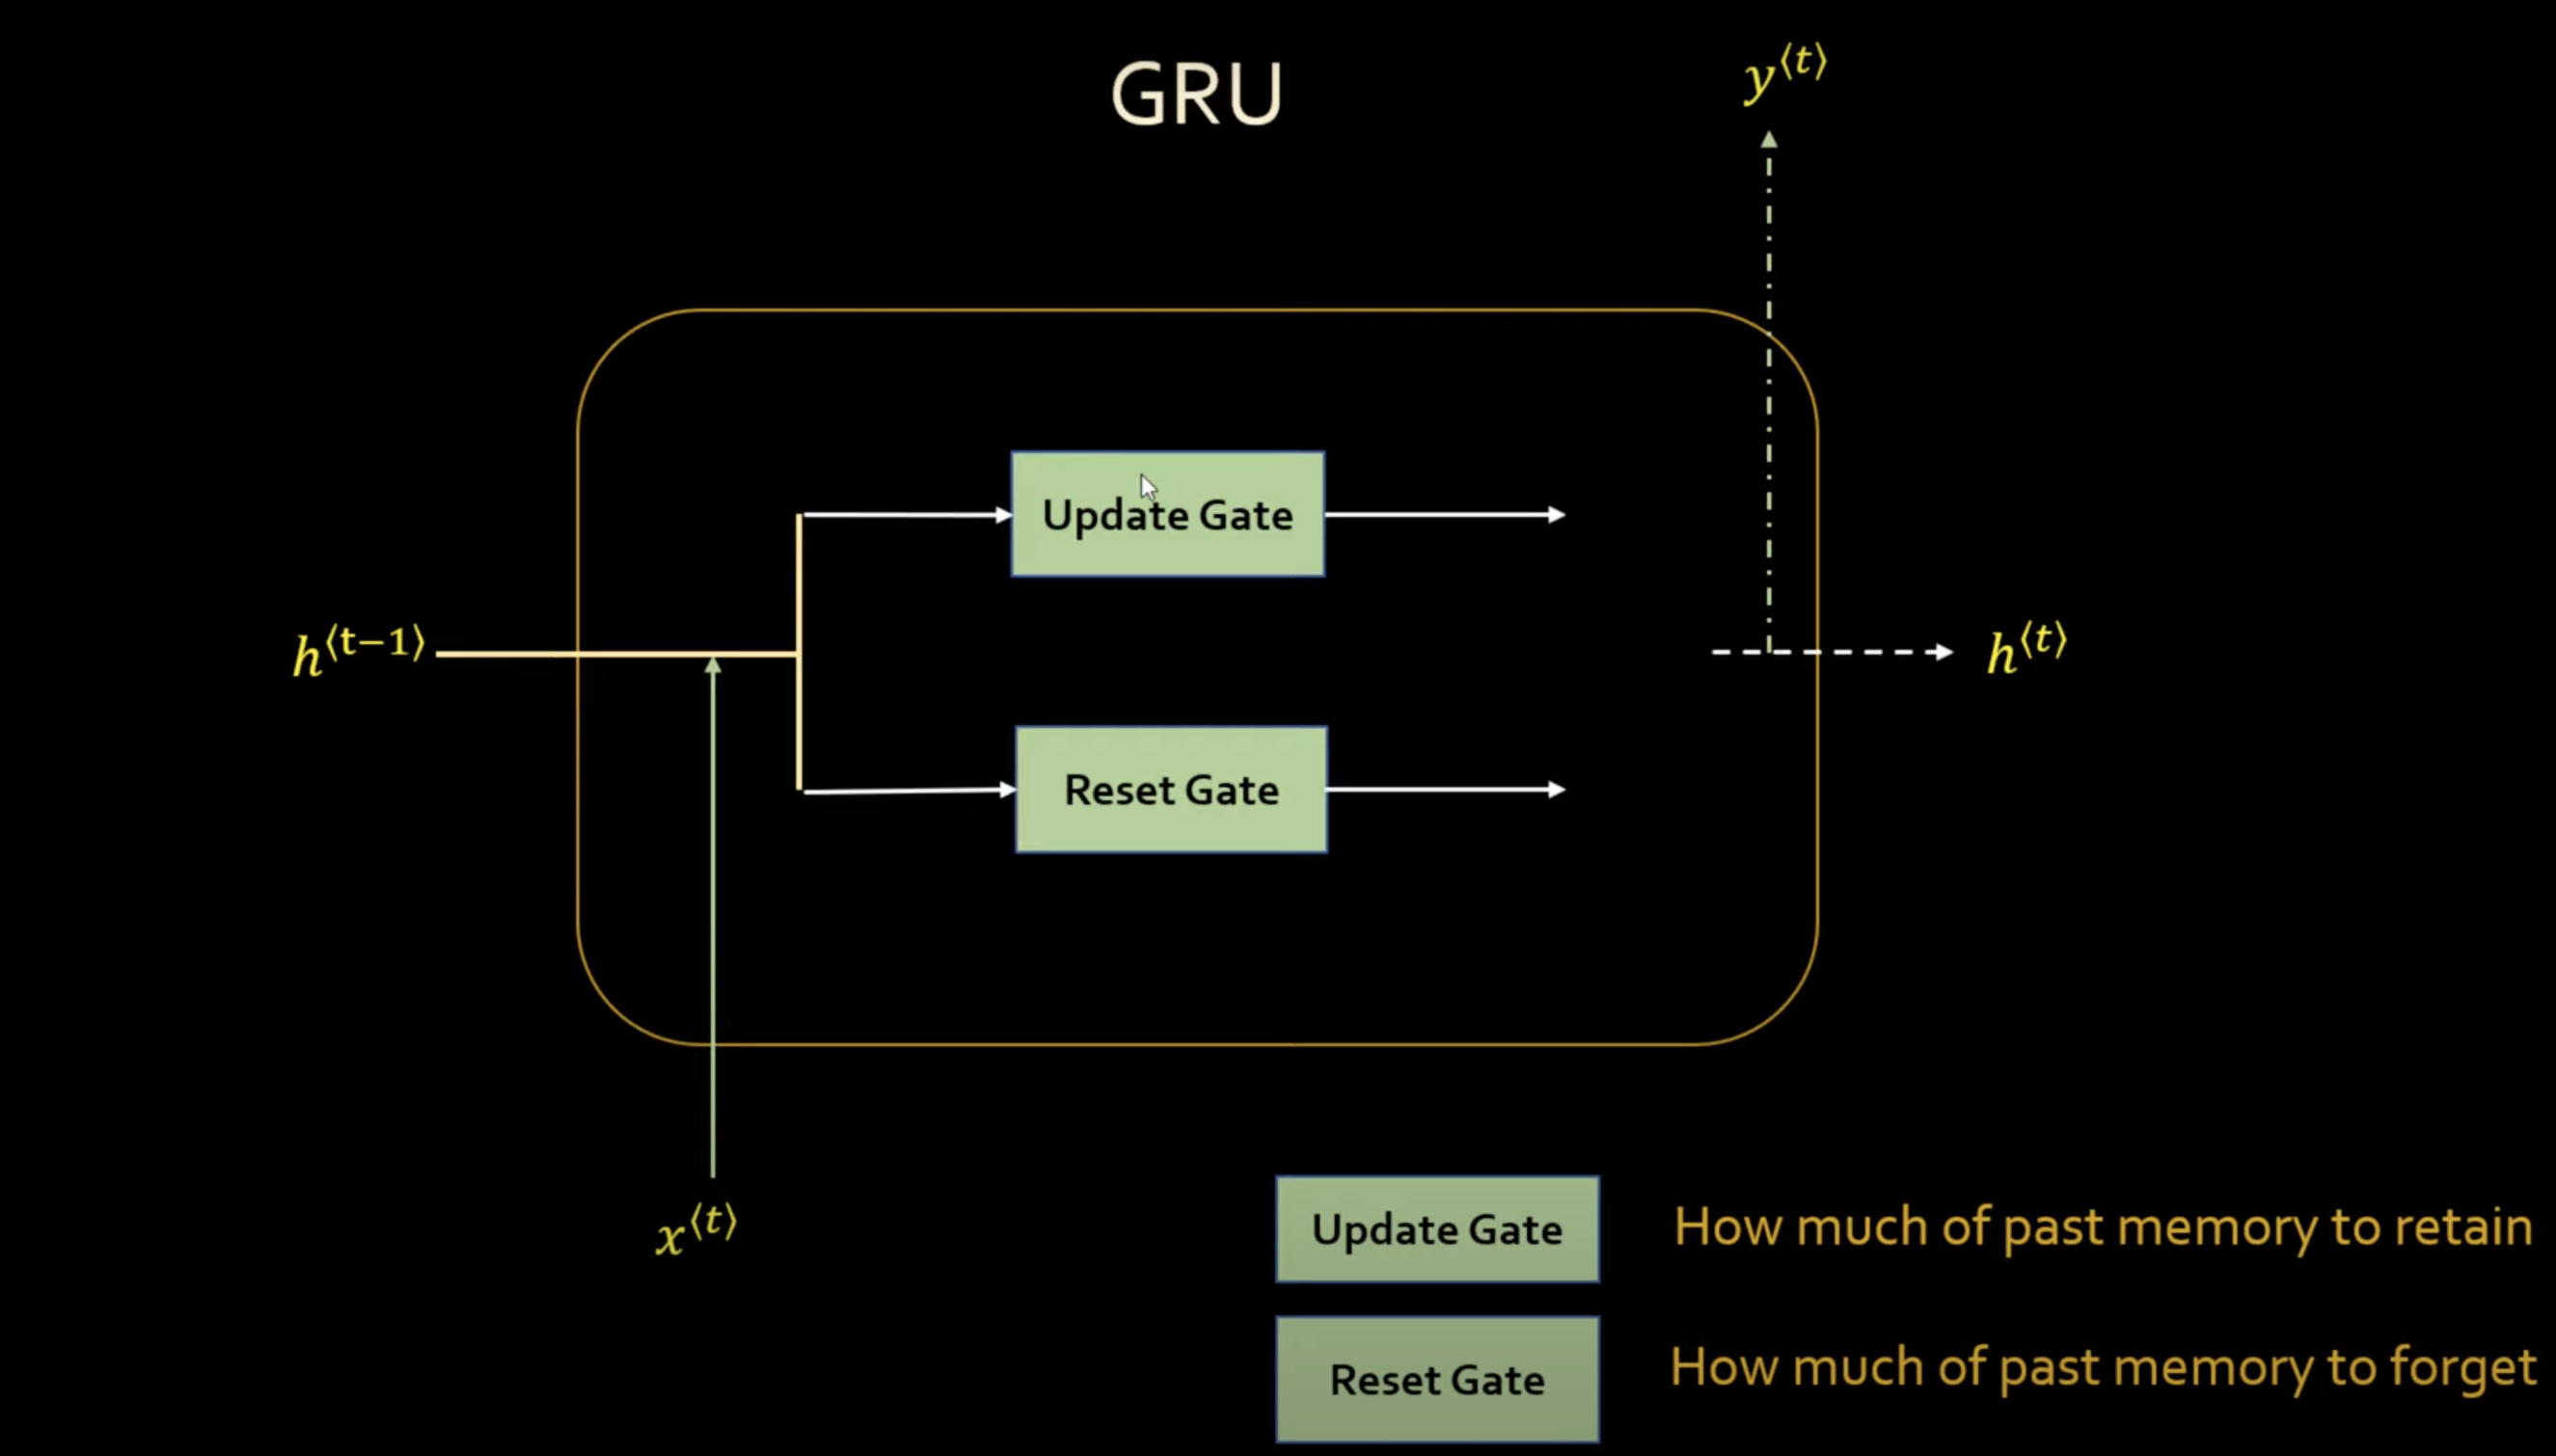

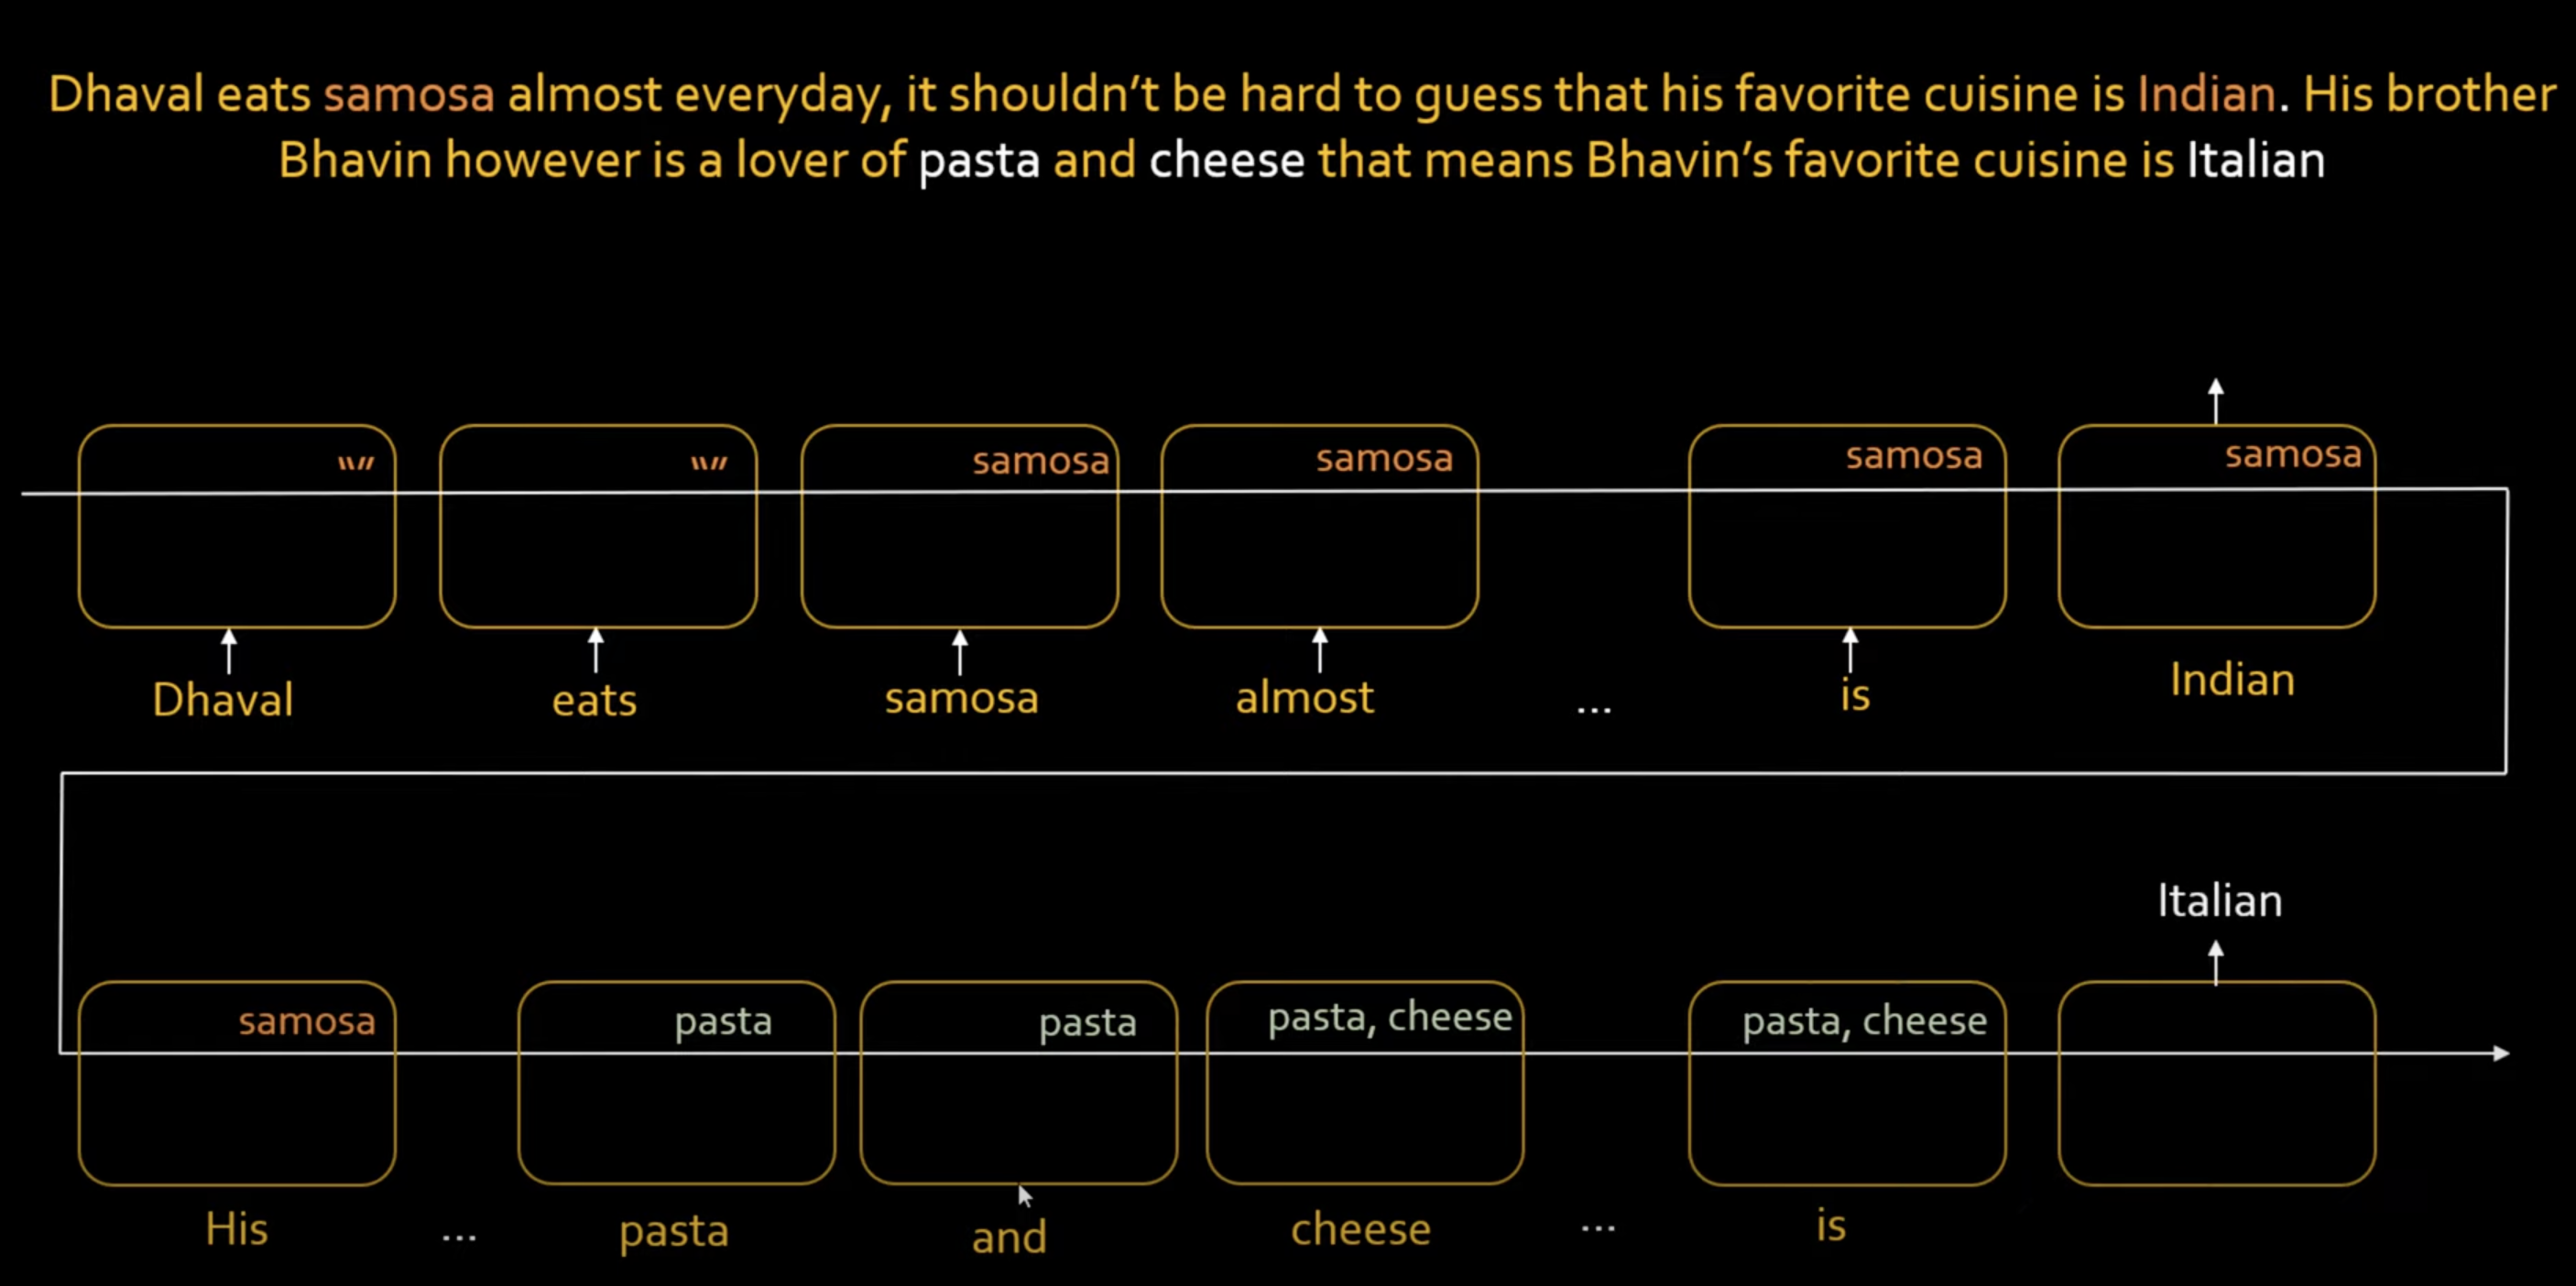

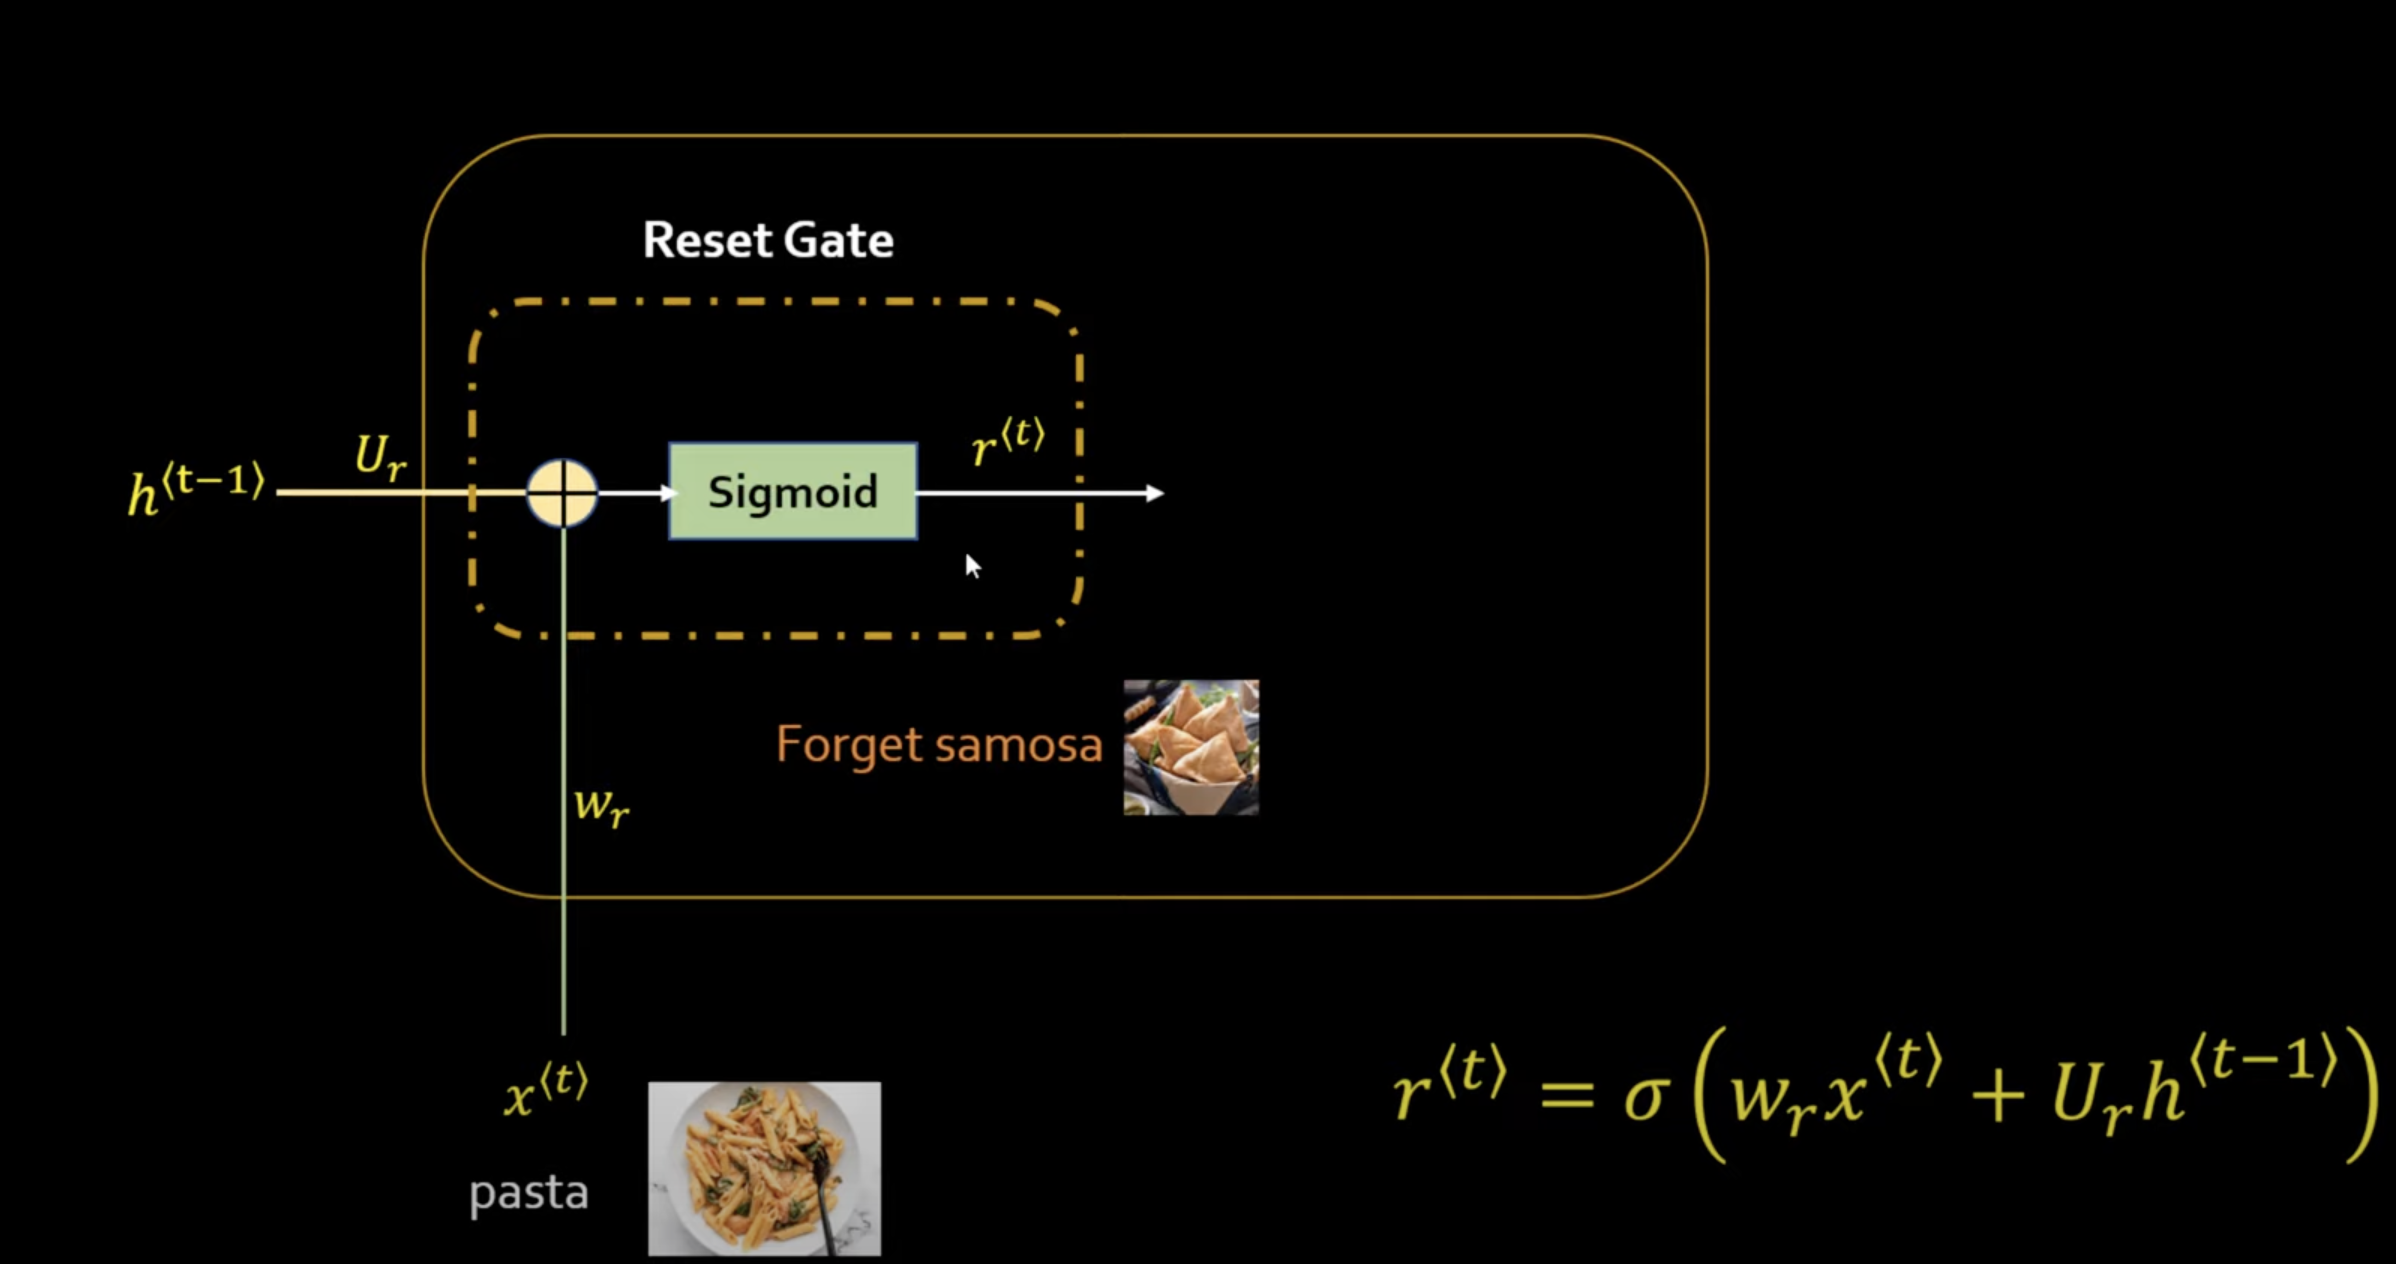

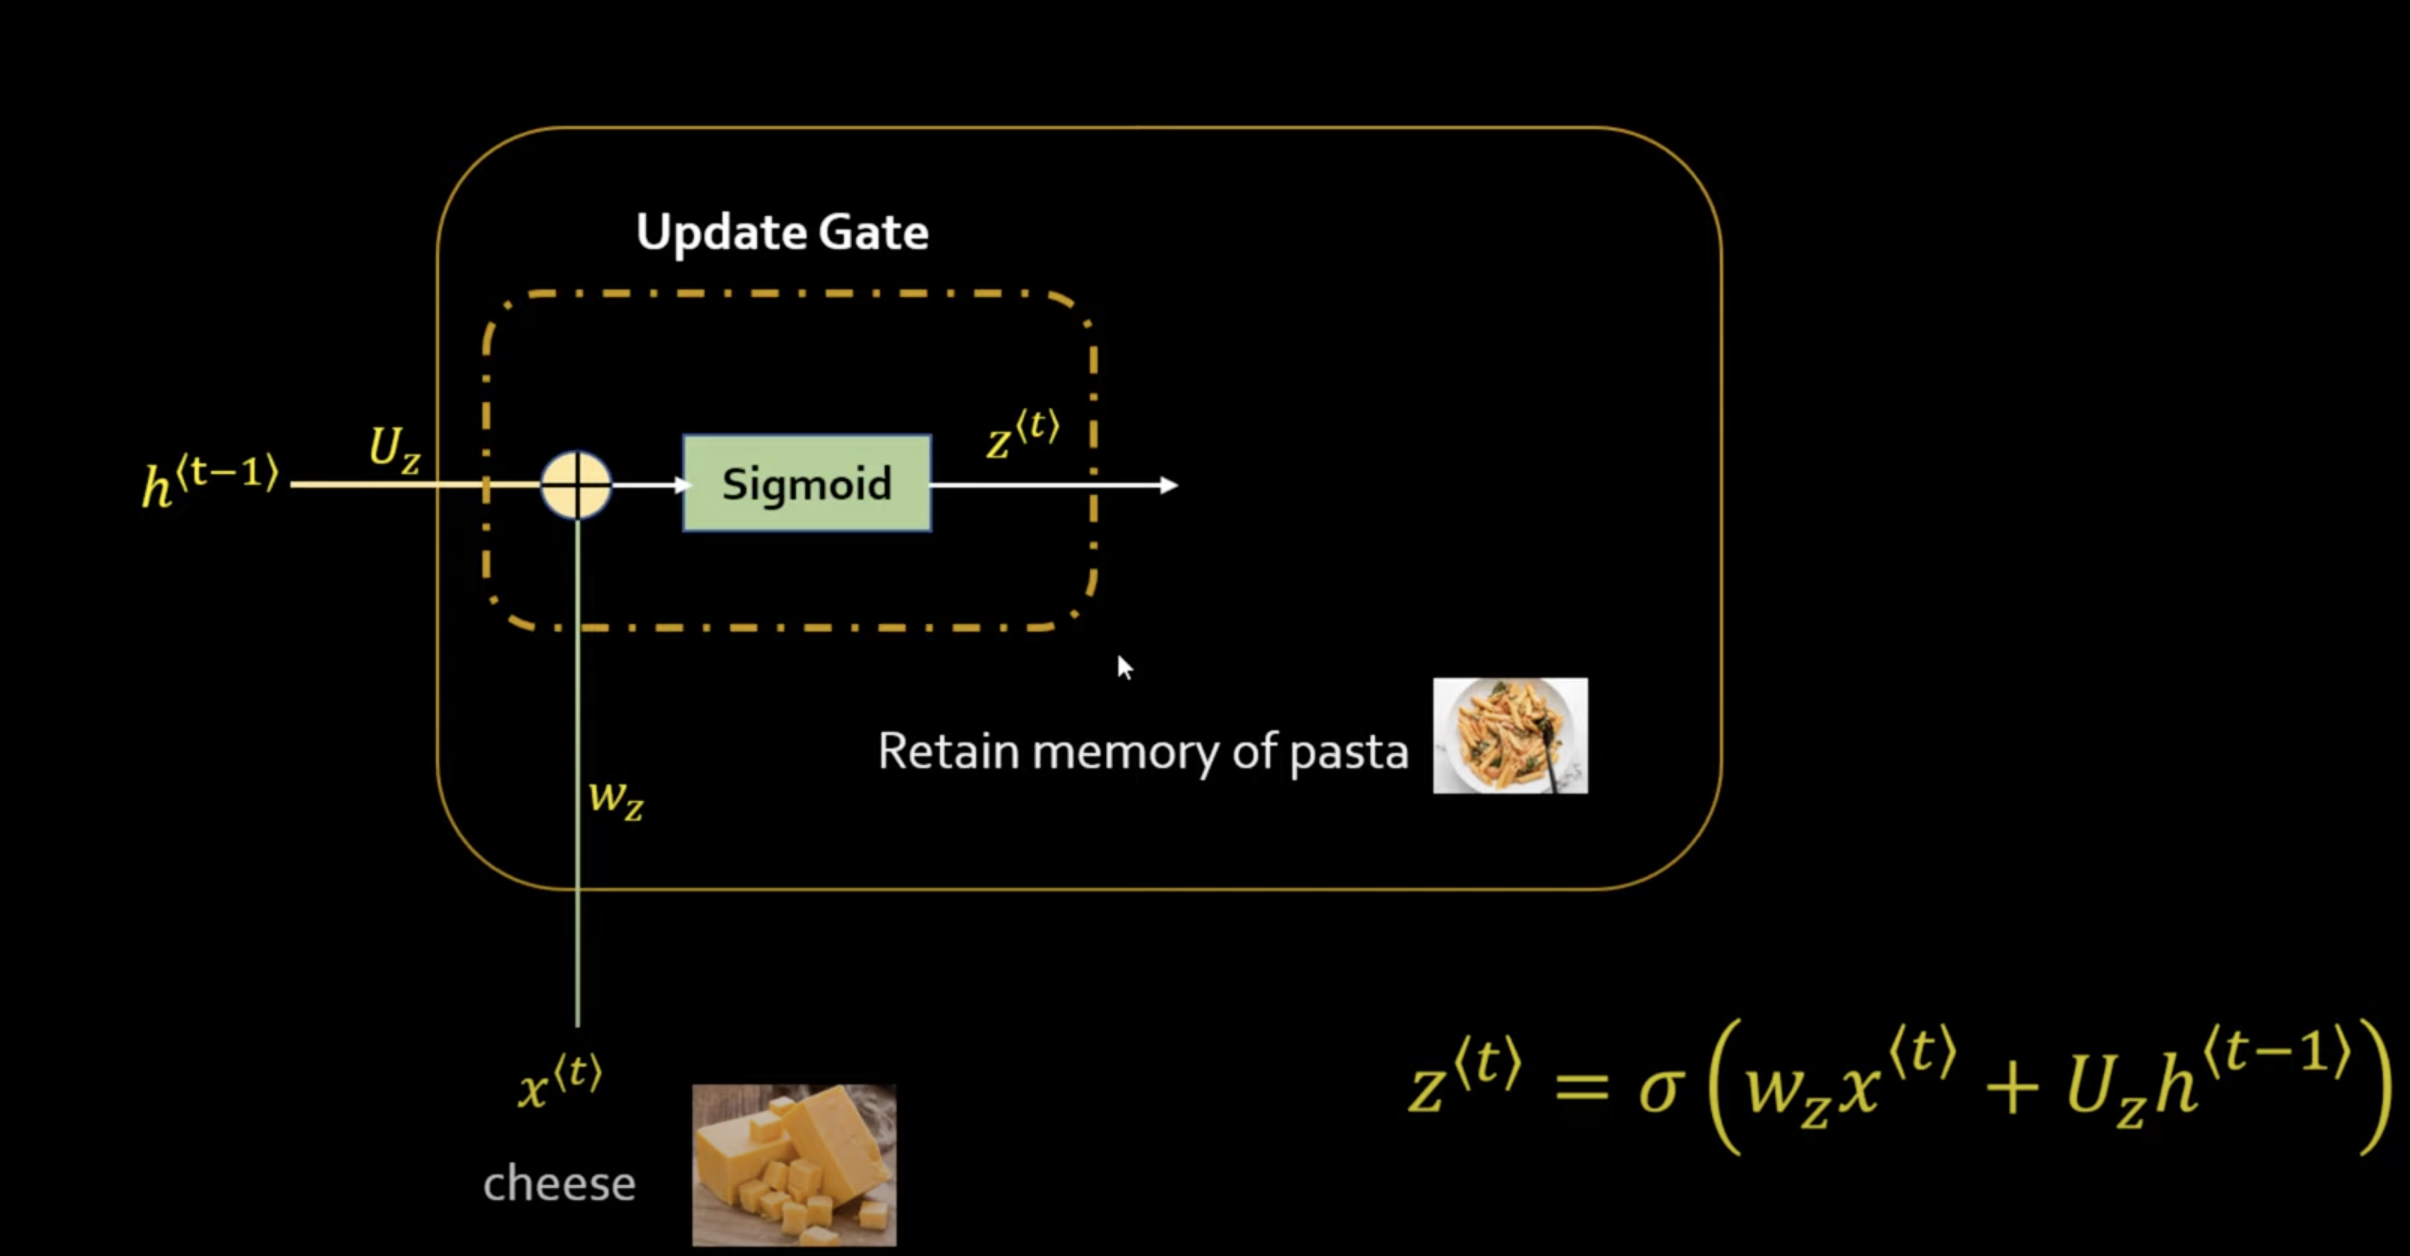

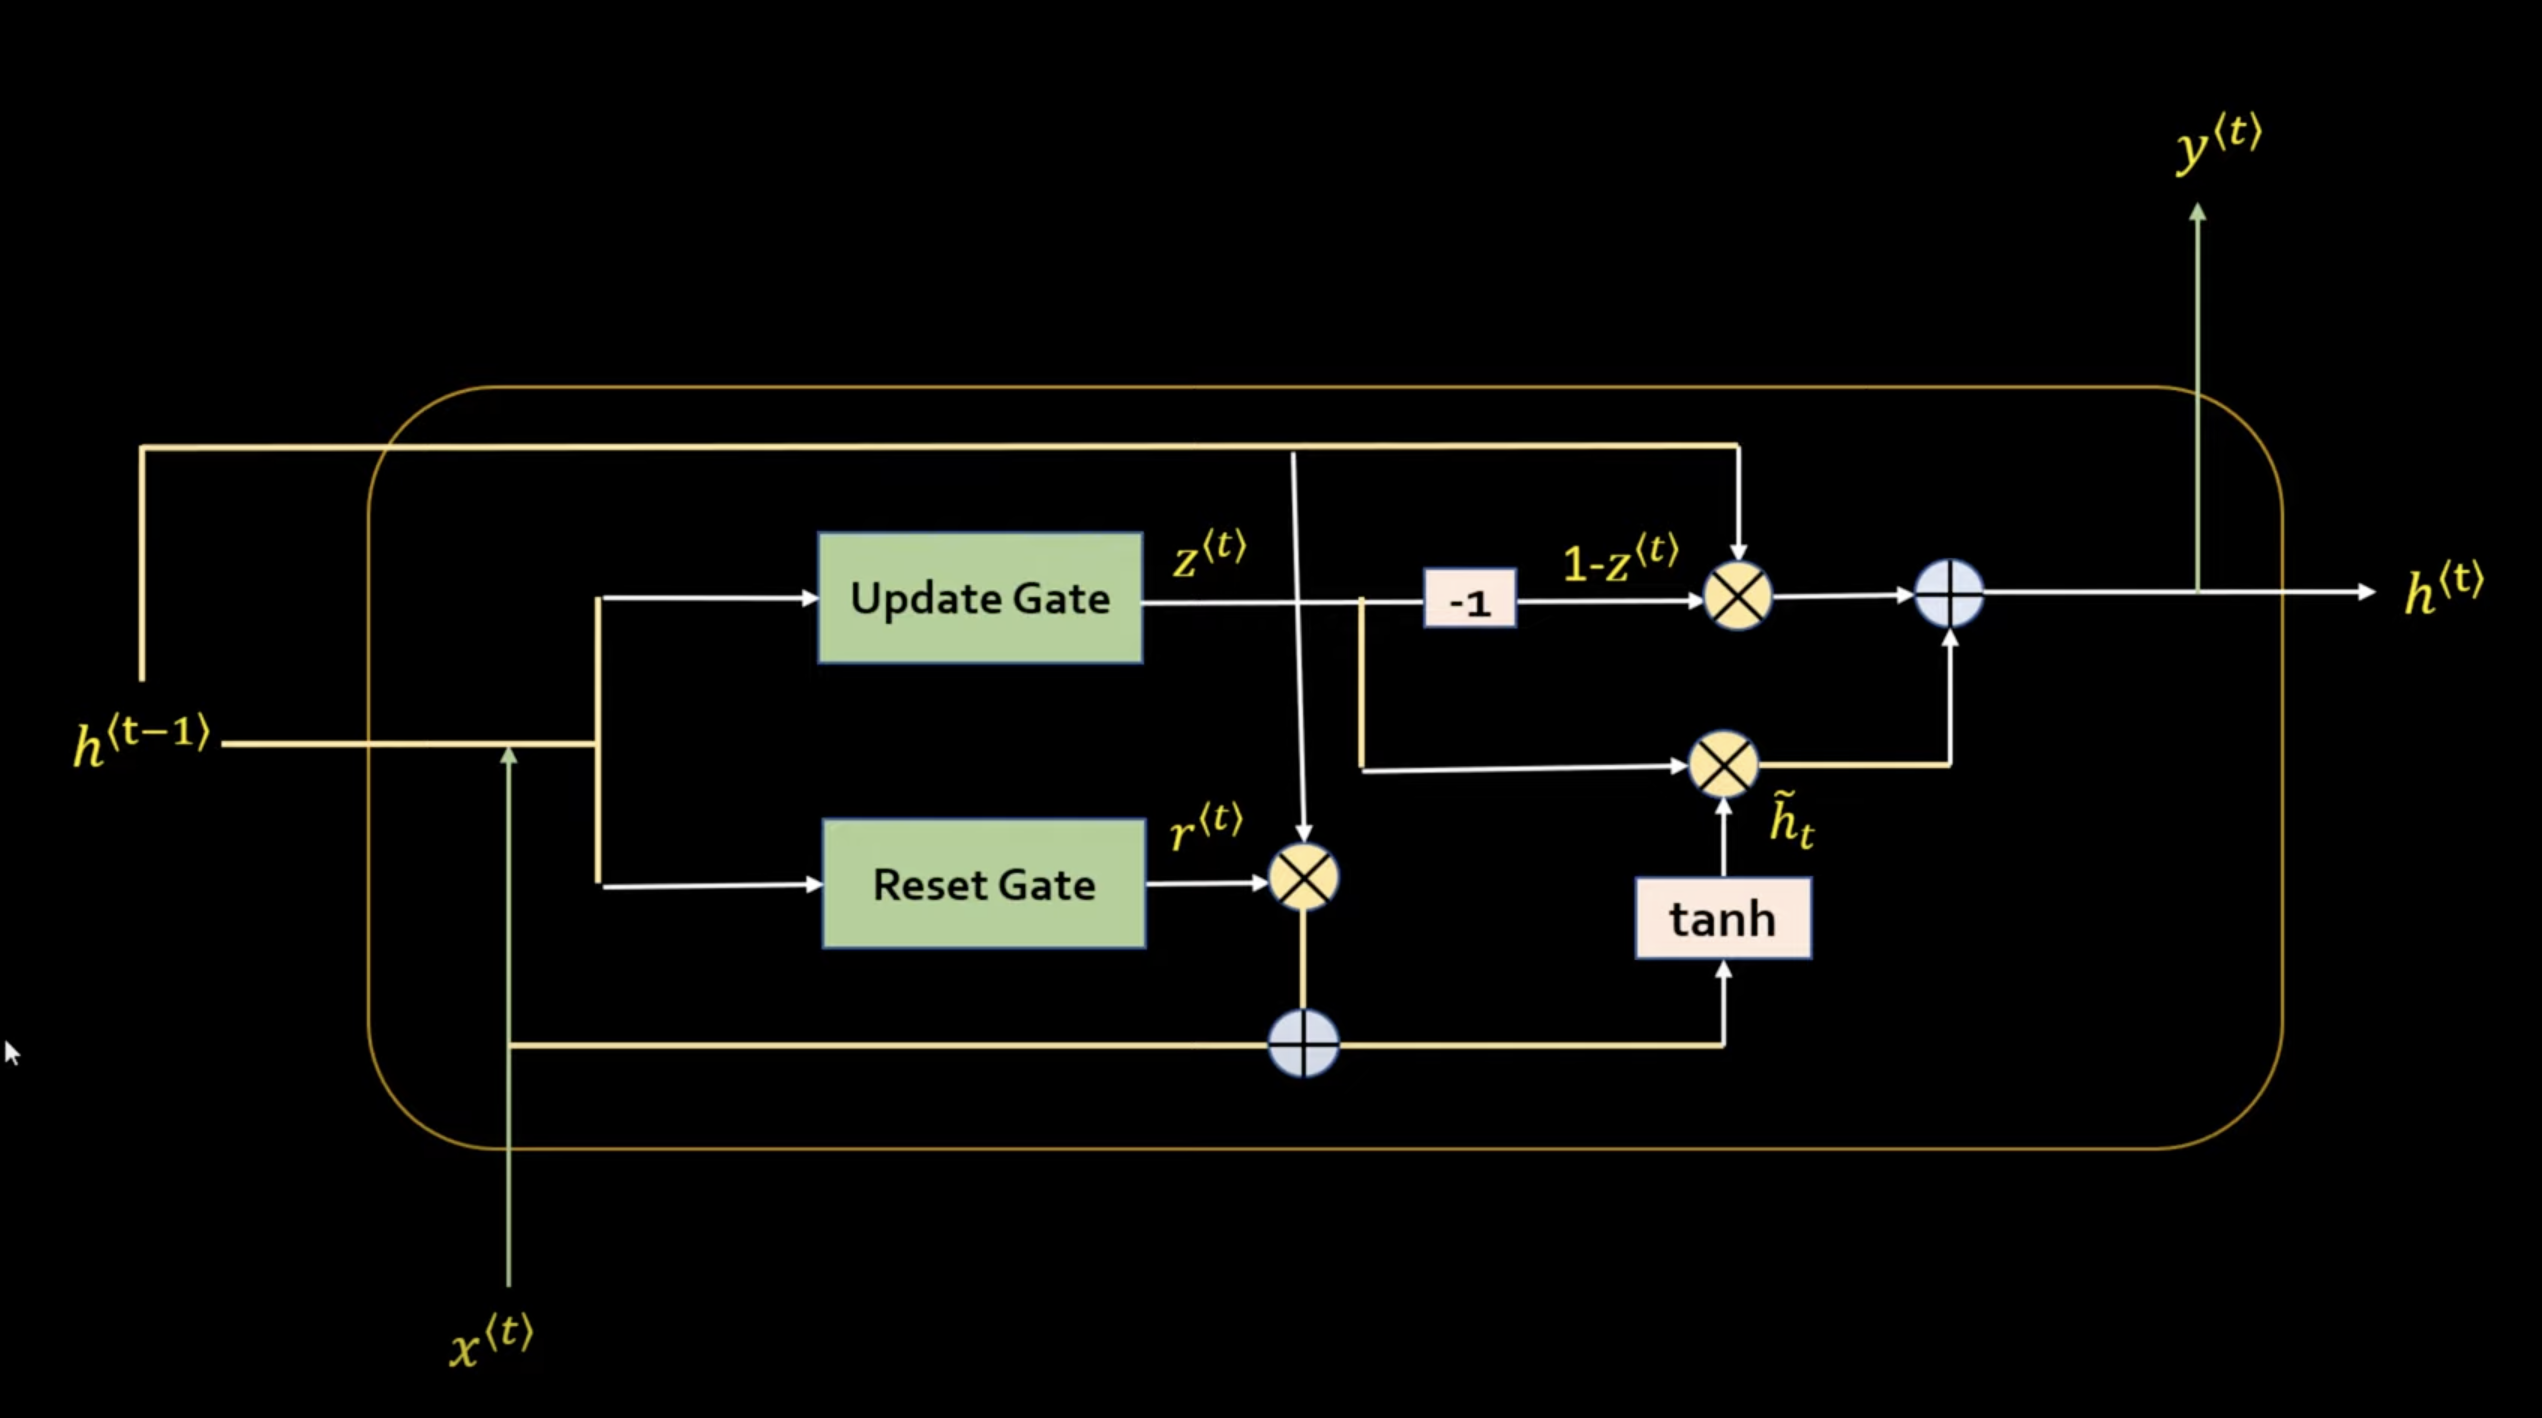

Reference : https://www.youtube.com/watch?v=tOuXgORsXJ4



*   Like LSTM, GRU is designed to model sequential data by allowing information to be selectively remembered or forgotten over time. However, GRU has a simpler architecture than LSTM, with fewer parameters, which can make it easier to train and more computationally efficient.


*   The main difference between GRU and LSTM is the way they handle the memory cell state. In LSTM, the memory cell state is maintained separately from the hidden state and is updated using three gates: the input gate, output gate, and forget gate. In GRU, the memory cell state is replaced with a “candidate activation vector,” which is updated using two gates: the reset gate and update gate.



*   The reset gate determines how much of the previous hidden state to forget. It takes as input the previous hidden state and the current input, and produces a vector of numbers between 0 and 1 that controls the degree to which the previous hidden state is “reset” at the current time step.

*   The update gate determines how much of the candidate activation vector to incorporate into the new hidden state. It takes as input the previous hidden state and the current input, and produces a vector of numbers between 0 and 1 that controls the degree to which the candidate activation vector is incorporated into the new hidden state.

*   The candidate activation vector is a modified version of the previous hidden state that is “reset” by the reset gate and combined with the current input. It is computed using a tanh activation function that squashes its output between -1 and 1.








###2. Dataset: Air Passengers Dataset
For this tutorial, we'll use the classic Air Passengers dataset, which contains monthly totals of international airline passengers from 1949 to 1960. This dataset is ideal for demonstrating time series prediction as it has a clear seasonal pattern and trend.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [ ]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url)
data = df['Passengers'].values.astype(float)

#Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data.reshape(-1, 1))

#Create input sequences for gru
#Converts the time series data into sequences of seq_length time steps.
#The inputs (X) are seq_length past values.
#The targets (y) are the next value in the series.
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

#Seq length -> number of time steps to look back
seq_length = 12
X, y = create_sequences(data_normalized, seq_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

###Why This Dataset is Suitable for GRUs

Temporal Dependencies: The dataset shows yearly patterns with increasing amplitude, where each month is influenced by previous months.
Seasonality: There's a clear yearly cycle with peaks in summer months.
Long-term Trend: The overall upward trend demonstrates long-term dependencies that GRUs can capture.
Non-linear Patterns: The multiplicative nature of the seasonality and trend is non-linear, which neural networks can model.

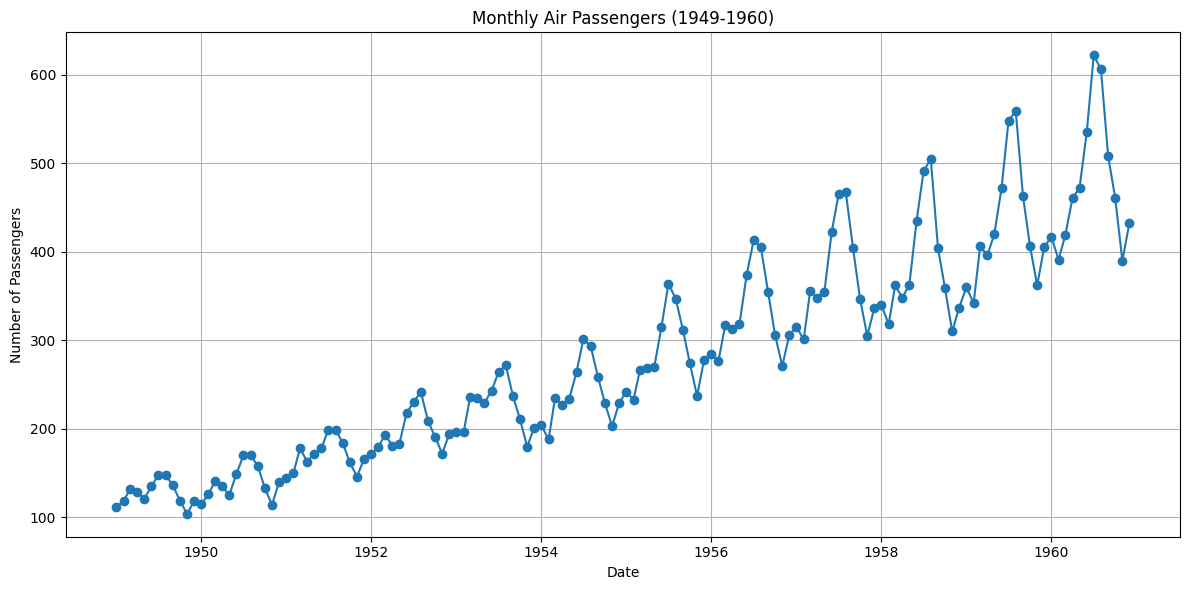

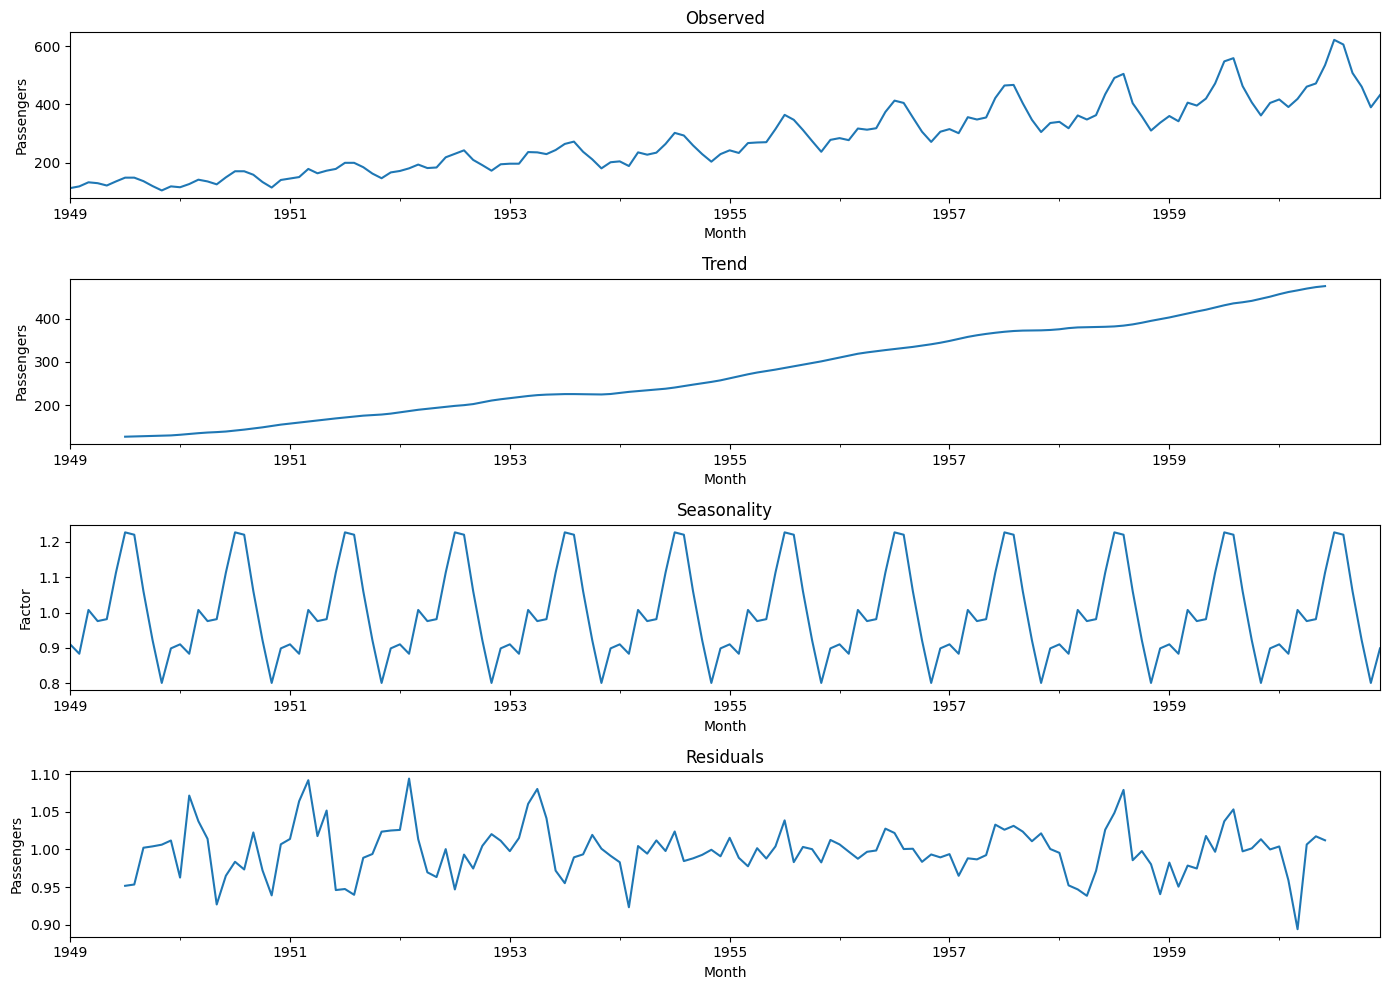

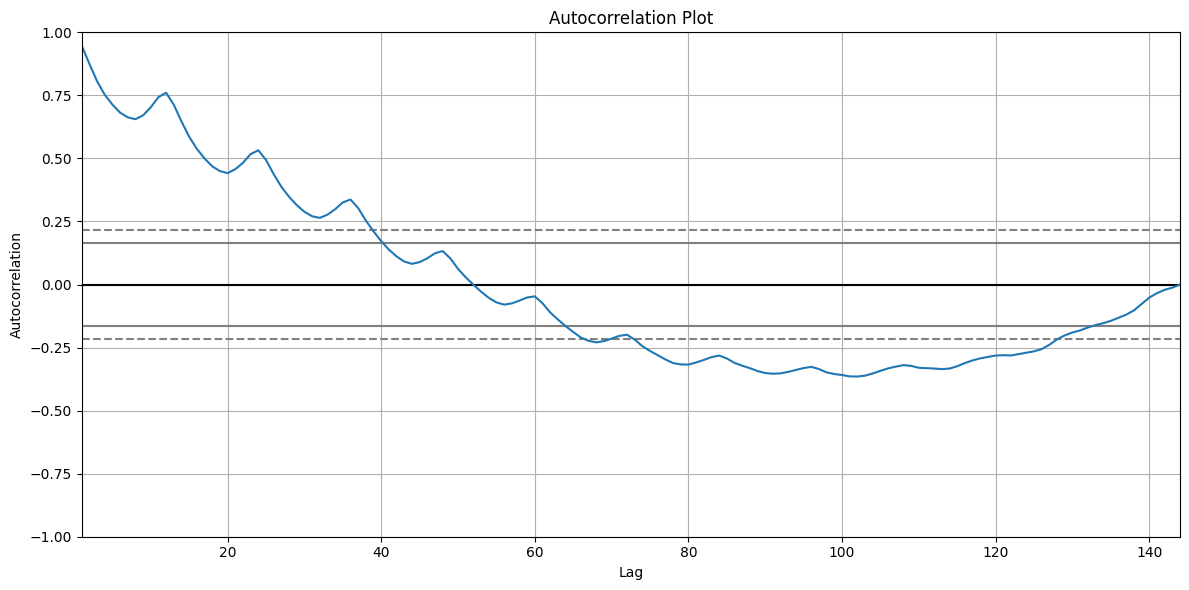

In [ ]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url)
df['Month'] = pd.to_datetime(df['Month'])
data = df['Passengers'].values.astype(float)

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['Passengers'], marker='o', linestyle='-')
plt.title('Monthly Air Passengers (1949-1960)')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.tight_layout()
plt.show()

# Analyze seasonality and trend
from statsmodels.tsa.seasonal import seasonal_decompose

# Convert to pandas Series with datetime index
ts = pd.Series(data, index=df['Month'])
decomposition = seasonal_decompose(ts, model='multiplicative', period=12)

# Plot decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
ax1.set_ylabel('Passengers')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
ax2.set_ylabel('Passengers')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonality')
ax3.set_ylabel('Factor')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residuals')
ax4.set_ylabel('Passengers')
plt.tight_layout()
plt.show()

# Autocorrelation plot
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(12, 6))
autocorrelation_plot(ts)
plt.title('Autocorrelation Plot')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2, output_size=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        out, _ = self.gru(x, h0)  # out:(batch_size, seq_length, hidden_size)

        out = self.fc(out[:, -1, :])
        return out

model = GRUModel(input_size=1, hidden_size=64, num_layers=2, output_size=1)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [10/100], Loss: 0.0072
Epoch [20/100], Loss: 0.0063
Epoch [30/100], Loss: 0.0052
Epoch [40/100], Loss: 0.0042
Epoch [50/100], Loss: 0.0037
Epoch [60/100], Loss: 0.0031
Epoch [70/100], Loss: 0.0028
Epoch [80/100], Loss: 0.0027
Epoch [90/100], Loss: 0.0018
Epoch [100/100], Loss: 0.0024


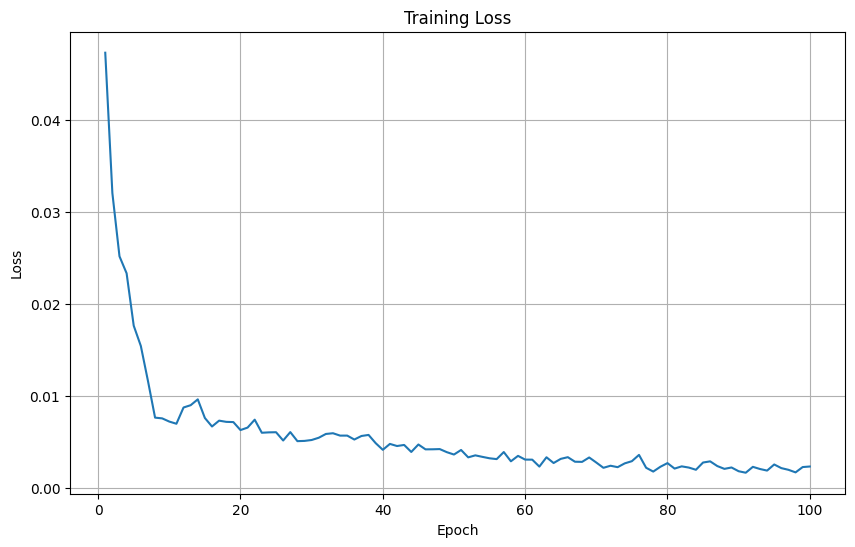

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return losses


num_epochs = 100
losses = train_model(model, train_loader, criterion, optimizer, num_epochs)


plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

Test RMSE: 41.57


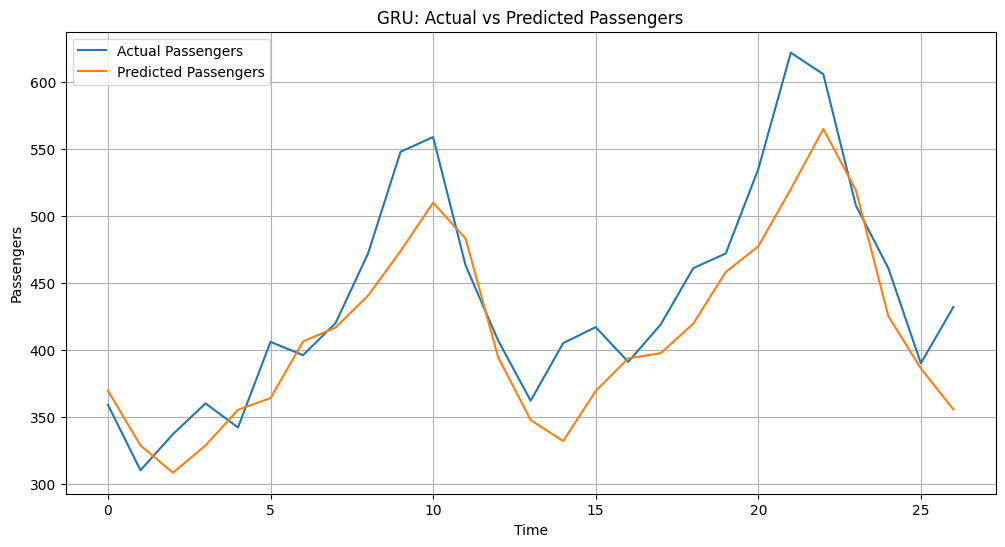

In [ ]:
def evaluate_model(model, test_loader, criterion, scaler):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())


    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

    rmse = math.sqrt(mean_squared_error(actuals, predictions))

    return predictions, actuals, rmse

predictions, actuals, rmse = evaluate_model(model, test_loader, criterion, scaler)
print(f'Test RMSE: {rmse:.2f}')

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual Passengers')
plt.plot(predictions, label='Predicted Passengers')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('GRU: Actual vs Predicted Passengers')
plt.legend()
plt.grid(True)
plt.show()

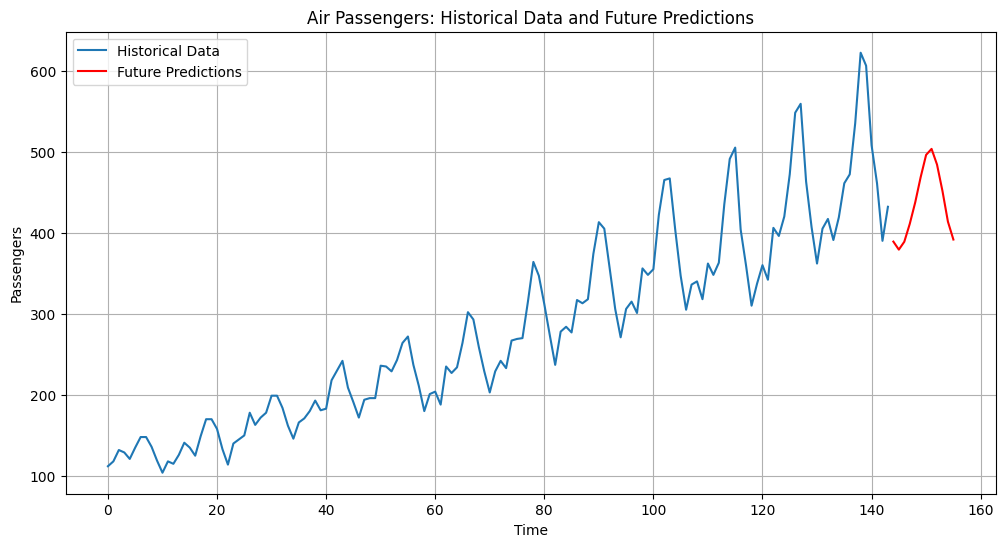

In [ ]:
def predict_future(model, last_sequence, n_steps, scaler):
    model.eval()

    current_sequence = last_sequence.copy()
    future_predictions = []

    with torch.no_grad():
        for _ in range(n_steps):

            x = torch.tensor(current_sequence).reshape(1, seq_length, 1).float().to(device)


            pred = model(x)
            future_predictions.append(pred.item())

            # Update sequence by removing the first value and adding the prediction
            current_sequence = np.append(current_sequence[1:], pred.item())

    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    return future_predictions

last_sequence = data_normalized[-seq_length:].reshape(seq_length, 1)
s
future_horizon = 12
future_predictions = predict_future(model, last_sequence, future_horizon, scaler)

plt.figure(figsize=(12, 6))
plt.plot(data, label='Historical Data')

future_timeline = np.arange(len(data), len(data) + future_horizon)
plt.plot(future_timeline, future_predictions, label='Future Predictions', color='red')

plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Air Passengers: Historical Data and Future Predictions')
plt.legend()
plt.grid(True)
plt.show()

##GRU Follow-Up In-Class Assignment: Hourly Temperature Forecasting
Overview

In this in-class assignment, you'll apply Gated Recurrent Units (GRUs) to hourly temperature forecasting. Temperature data exhibits multiple patterns (daily cycles, weekly variations, and seasonal trends), making it an excellent next step for practicing with GRUs.

###Dataset
You'll work with the "Beijing PM2.5 Data" dataset, which includes hourly meteorological data for Beijing from 2010 to 2014. For this assignment, we'll focus on predicting temperature values.

####Dataset Details:

Source: UCI Machine Learning Repository

Features: We'll use the 'TEMP' (temperature) column

Time period: 2010-2014

Sampling rate: Hourly

Assignment Tasks
###Task 1: Data Preparation

Load the dataset using the provided code

Focus on the 'TEMP' column for prediction

Handle missing values by forward fill or interpolation

Normalize the data using MinMaxScaler

Create sequences with a lookback window of 24 hours (predict the next hour)

Split into training (80%) and testing (20%) sets

###Task 2: Model Implementation

Implement a GRU model with the following specifications:

Input size: 1 (single feature)

Hidden size: 32

Number of layers: 2

Output size: 1 (predict next hour)

Dropout: 0.1 (for regularization)


Train the model for 50 epochs using:

Loss function: Mean Squared Error

Optimizer: Adam with learning rate 0.001

Batch size: 32

###Task 3: Evaluation and Visualization

Evaluate the model on the test set and calculate:

Root Mean Squared Error (RMSE)

Mean Absolute Error (MAE)


Create the following visualizations:

Training loss curve

Actual vs. predicted values for a sample week

Daily patterns in predictions vs. actual values

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from datetime import datetime

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Load the dataset (This URL should be reliable)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv"
df = pd.read_csv(url)

# Prepare datetime column
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('date', inplace=True)

# Select temperature data
temp_data = df['TEMP'].copy()

# TODO: Handle missing values
# temp_data = temp_data.fillna(method='ffill')

# TODO: Create sequences (lookback of 24 hours)
# def create_sequences(data, seq_length):
#     xs, ys = [], []
#     for i in range(len(data) - seq_length):
#         x = data[i:i+seq_length]
#         y = data[i+seq_length]
#         xs.append(x)
#         ys.append(y)
#     return np.array(xs), np.array(ys)

# TODO: Split data, create PyTorch tensors and DataLoaders

# TODO: Implement and train your GRU model
# class GRUModel(nn.Module):
#     def __init__(self, input_size=1, hidden_size=32, num_layers=2, output_size=1):
#         super(GRUModel, self).__init__()
#         # TODO: Implement model architecture

# TODO: Evaluate the model and create visualizations
